## House Prices: Advanced Regression Techniques

### by Dominic Reichl

Goal: predict house prices with up to 79 explanatory variables for Kaggle competition

Method: gradient boosting and lasso regression

Overview:
1. Load modules and data
2. Remove outliers
3. Normalize target
4. Remove attributes
5. Fill missing values
6. Engineer features
7. Run regressions
8. Make predictions

## 1. Load modules and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## 2. Remove outliers

We drop two outliers that represent a huge living area at very low price because they would unduly skew our model.

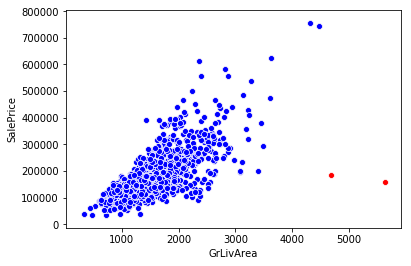

In [2]:
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'], color='red')
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'], color='blue')

## 3. Normalize target

Since our dependent variable 'SalePrice' is right-skewed, we log-transform it.

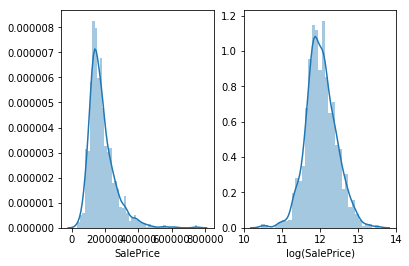

In [3]:
target = train.pop('SalePrice').values
fig, axes = plt.subplots(1,2)
sns.distplot(target, axlabel='SalePrice', ax=axes[0])
target = np.log1p(target)
sns.distplot(target, axlabel='log(SalePrice)', ax=axes[1])

## 4. Remove attributes

We pop the test set 'Id' column (needed for our submission file) and remove that column from the train set because it lacks explanatory value.

Although usually not recommended, we put the train and test set together to prevent matrix shape disparity when creating dummy variables later. We store the number of rows in the training data (ntrain) for later separation.

Due to its extreme class imbalance, we drop the column 'Utilities'.

In [4]:
train.drop('Id', axis=1, inplace=True)
testID = test.pop('Id')

ntrain = train.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

print(data.Utilities.value_counts())
data = data.drop(['Utilities'], axis=1)

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64


## 5. Fill missing values

From data_description.txt we learn that most values are not actually missing; rather, they represent physically missing items. So we fill in these cells with 'None' for string columns and '0' for numeric columns.

We then impute the missing values in seven categorical columns with the most frequent category because they have strong class imbalances and only 1-4 values missing. Finally, for 'LotFrontage', we use the median value depending on the type of 'Neighborhood'.

In [5]:
print('Missing values in data frame:', sum([data[col].isnull().sum() for col in data.columns]))

print("Filling in 'None' in string columns")
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MSSubClass',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
    
print("Filling in '0' in numeric columns")
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    data[col] = data[col].fillna(0)
    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'):
    print("Imputing mode for", data[col].isnull().sum(), "missing values in", col)
    data[col] = data[col].fillna(data[col].mode()[0])
    
print("Imputing grouped median for", data['LotFrontage'].isnull().sum(), "missing values in 'LotFrontage'")
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

print('Missing values in data frame:', 'Yes' if True in [data[col].isnull().any() for col in data.columns] else None)

Missing values in data frame: 13956
Filling in 'None' in string columns
Filling in '0' in numeric columns
Imputing mode for 4 missing values in MSZoning
Imputing mode for 1 missing values in Electrical
Imputing mode for 1 missing values in KitchenQual
Imputing mode for 1 missing values in Exterior1st
Imputing mode for 1 missing values in Exterior2nd
Imputing mode for 1 missing values in SaleType
Imputing mode for 2 missing values in Functional
Imputing median for 486 missing values in 'LotFrontage'
Missing values in data frame: None


## 6. Engineer features

We create one new feature before we transform four numeric features into string objects, and vice versa for twenty-six others. Then we box-cox-transform highly skewed numeric features. Finally, we create dummy variables from our categorical features. 

In [6]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

for col in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold'):
    data[col] = data[col].astype(str)
    
from sklearn.preprocessing import LabelEncoder
for col in ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual',
            'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',  'BsmtFinType2',
            'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape',
            'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold']:
        vals = list(data[col].values)
        encoder = LabelEncoder()
        encoder.fit(vals)
        data[col] = encoder.transform(vals)
        
from scipy.stats import skew
from scipy.special import boxcox1p
numeric_features = data.dtypes[data.dtypes != "object"].index
skewed_features = data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_features})
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
for feature in skewness.index:
    data[feature] = boxcox1p(data[feature], 0.15)
    
data = pd.get_dummies(data)

## 7. Run regressions

After splitting our data, we test two models: gradient boosting and lasso regression.

In [7]:
train = data[:ntrain]
test = data[ntrain:]

from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(train, target, test_size=0.2, random_state=42)

from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =5)
gbr.fit(X_train, y_train)
gbr_score = gbr.score(X_dev, y_dev)
print('Gradient boosting score:', gbr_score)

from sklearn.linear_model import LassoCV
lcv = LassoCV()
lcv.fit(X_train, y_train)
lcv_score = lcv.score(X_dev, y_dev)
print('Lasso regression score:', lcv_score)

Gradient boosting score: 0.913176183037666
Lasso regression score: 0.9231982258725984


## 8. Make predictions

These scores look good, so let's fit both models with the training data, compute their predictions for the test data, exponentiate them (because remember step 3), and load their averages into our submission file.

In [8]:
gbr.fit(train, target)
lcv.fit(train, target)

gbr_predictions = np.expm1(gbr.predict(test))
lcv_predictions = np.expm1(lcv.predict(test))
predictions = (gbr_predictions + lcv_predictions) / 2
print('Predictions:', predictions) # sanity check

results = pd.DataFrame({'Id': testID, 'SalePrice': predictions})
results.to_csv('submission.csv', index=False)

Predictions: [123017.47587579 157842.92414851 190952.44519131 ... 171752.03206123
 117962.68856198 217950.58501928]
